In [1]:
import torch
import matplotlib.pyplot as plt
import multiprocessing as mp
import sys
from pathlib import Path
from subprocess import check_output  # noqa: S404

import hydra
from hydra import compose, initialize
import pytorch_lightning as pl
import wandb
from hydra.utils import instantiate
from lightning_utilities.core.rank_zero import rank_zero_only
from loguru import logger
from omegaconf import DictConfig, OmegaConf
from cargpt.utils.logging import setup_logging

from einops import rearrange
from einops.layers.torch import Rearrange
from xformers.components.attention.core import scaled_query_key_softmax

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

import torchvision.transforms.functional as F
import numpy as np

from cargpt.components.episode import (
    EpisodeBuilder,
    Index,
    Modality,
    SpecialToken,
    Timestep,
    TokenType,
)

In [2]:
experiment ='smart-inference'
datamodule = 'gato-dry'

In [3]:
plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(32, 64))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [4]:
def setup(cfg: DictConfig):
    pl.seed_everything(
        cfg.seed,
        workers=True,
    )  # pyright: ignore[reportUnusedCallResult]

    logger.debug("instantiating model", target=cfg.model._target_)
    model: pl.LightningModule = instantiate(cfg.model)

    logger.debug("instantiating datamodule", target=cfg.datamodule._target_)
    datamodule: pl.LightningDataModule = instantiate(cfg.datamodule)

    return model, datamodule


In [5]:
def plot_attention(attn_matrix, column_names):

        # Convert tensor to numpy array
        tensor_np = attn_matrix.detach().cpu().numpy()
        
        # Plot each channel separately
        fig, axes = plt.subplots(1, 1, figsize=(12, 4))
        
        im = axes.imshow(tensor_np, cmap='hot')  # You can use any colormap you prefer
        axes.set_xticks(range(tensor_np.shape[1]))  # Set the number of ticks equal to the number of columns
        axes.set_xticklabels(column_names, rotation=45)  # Set column names as tick labels with rotation
        axes.set_yticks([])  # Remove y-axis ticks

        fig.colorbar(im, ax=axes)
                
        plt.tight_layout()
        plt.show()

def compute_entropy(attn_mat):

    return - ((attn_mat + 1e-5) * torch.log(attn_mat + 1e-5)).sum(dim=2).mean(dim=1)

In [6]:
mp.set_start_method("spawn", force=True)
mp.set_forkserver_preload(["torch"])
setup_logging()

In [7]:
# context initialization
# https://hydra.cc/docs/advanced/compose_api/
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name="train.yaml", overrides=[f"experiment={experiment}", f"datamodule={datamodule}", "paths.metadata_cache_dir=./yaak-datasets/metadata"])

In [8]:
model, datamodule = setup(cfg)

Seed set to 1337
2024-03-23 12:34:41.973 | DEBUG    | __main__ - instantiating model (target=cargpt.models.control_transformer.ControlTransformer.load_from_wandb_artifact)
wandb: Downloading large artifact model-sqe2e4lm:v1, 255.75MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
/home/harsimrat/.cache/pypoetry/virtualenvs/cargpt-Iy-Ercof-py3.11/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.2.0.post0
2024-03-23 12:34:44.927 | DEBUG    | __main__ - instantiating datamodule (target=cargpt.datamodules.GenericDataModule)
2024-03-23 12:34:47.967 | DEBUG    | yaak_datasets.dataset.dataset - processing (drive=Niro107-HQ/2023-05-12--12-05-15)
2024-03-23 12:34:47.969 | DEBUG    | yaak_datasets.dataset.dataset - processing (drive=Niro115-HQ/2023-05-16--10-47-33)
2024-03-23 12:34:48.000 | DEBUG    | yaak_datasets.io.metadata.dataframe -

In [9]:
dataloader = datamodule.train_dataloader()
iterator = iter(dataloader)
mean = torch.tensor(dataloader.dataset.config.samples.transforms[1].mean).to(model.device).reshape([1, 3, 1, 1])
std = torch.tensor(dataloader.dataset.config.samples.transforms[1].std).to(model.device).reshape([1, 3, 1, 1])

In [10]:
batch = next(iterator)

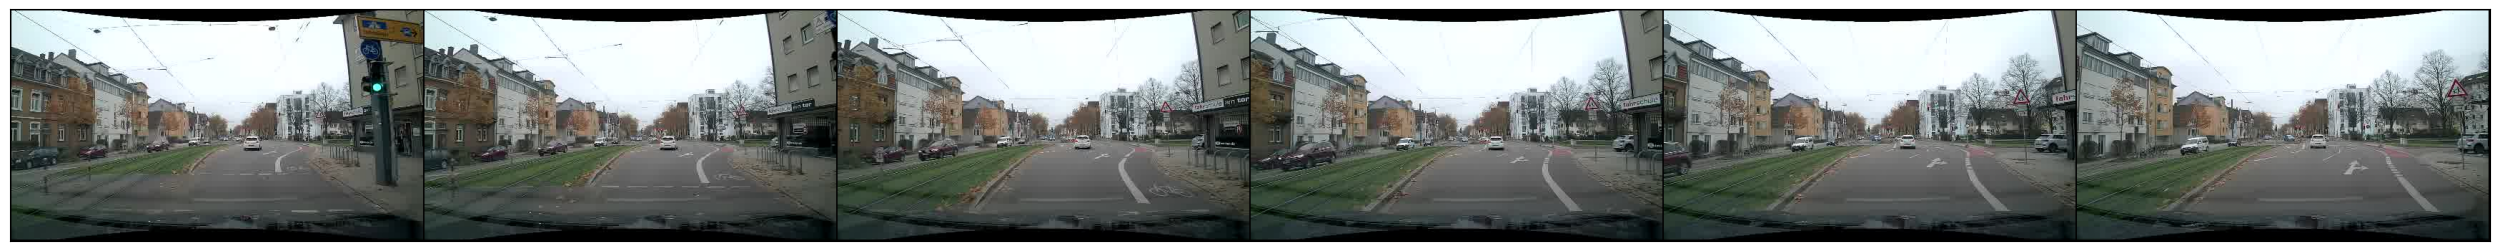

In [25]:
batch_index = 14
timestep = 5
inputs = model._build_input(batch).to('cuda:0')
grid = make_grid((inputs["image", "cam_front_left"][batch_index].clone() * std) + mean)
show(grid)

In [26]:
b, t = inputs.batch_size
episode = model.episode_builder.build_episode(inputs)
mask = model.objectives["inverse_dynamics"]._build_attention_mask(episode.index, episode.timestep)
x = model.encoder.encoders.blocks[0].f.net.norm(episode.packed_embeddings)
query, key, value = model.encoder.encoders.blocks[0].f.net.sublayer.in_proj_container(x, x, x)
attn = scaled_query_key_softmax(query, key, att_mask=mask.data)
attn_reshaped = rearrange(attn, 'b (t_from s_from) (t_to s_to) -> b (t_from s_from) t_to s_to', t_from=6, t_to=6)
attn_parsed = episode.index.parse(attn_reshaped)

In [27]:
action_summary_attn = attn_parsed["special", "action_summary"][batch_index, timestep, 0, timestep, 182:]
column_names = ["observation_summary", "observation_history", "gas_pedal", "brake_pedal", "steering_angle", "action_summary"]

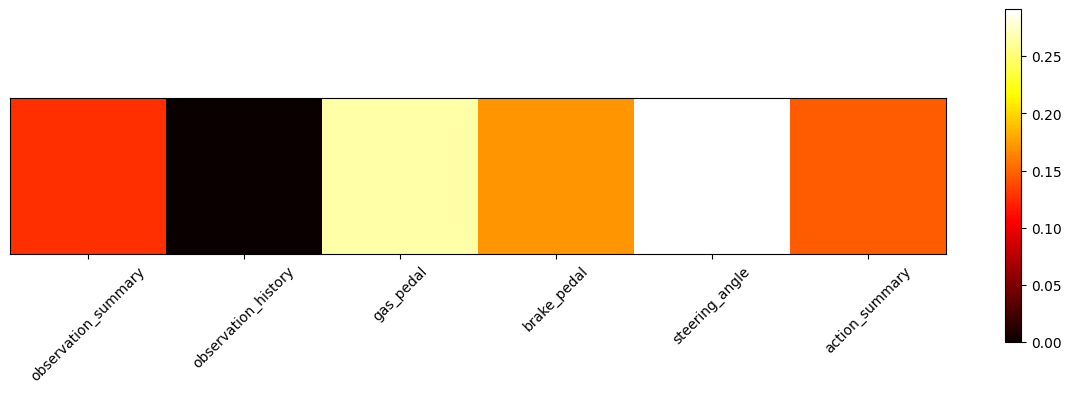

In [28]:
plot_attention(action_summary_attn.reshape([1, -1]), column_names)

In [29]:
action_summary_attn = attn_parsed["continuous", "brake_pedal"][batch_index, timestep, 0, timestep, 182:]
column_names = ["observation_summary", "observation_history", "gas_pedal", "brake_pedal", "steering_angle", "action_summary"]

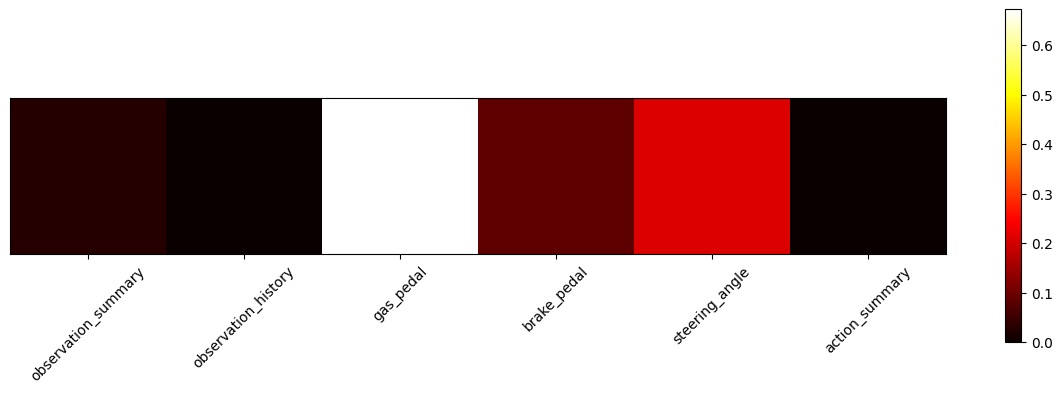

In [30]:
plot_attention(action_summary_attn.reshape([1, -1]), column_names)

In [31]:
observation_summary_attn = attn_parsed["special", "observation_summary"][batch_index, timestep, 0, timestep, :180]
column_names = [f"{i}" for i in range(18)]

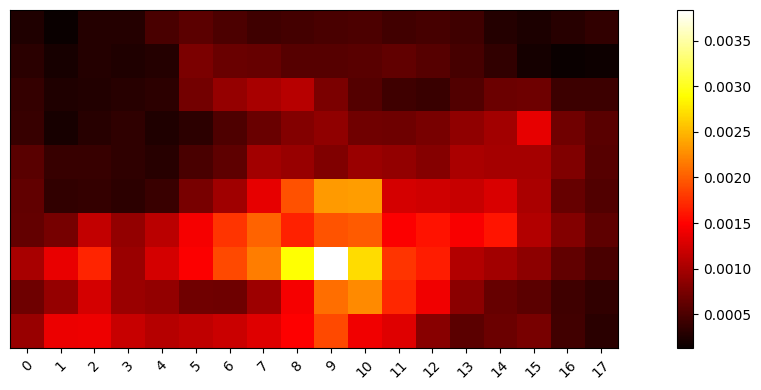

In [32]:
plot_attention(observation_summary_attn.reshape([10, 18]), column_names)

In [33]:
observation_summary_attn = attn_parsed["special", "observation_summary"][batch_index, timestep, 0, timestep, 180:182]

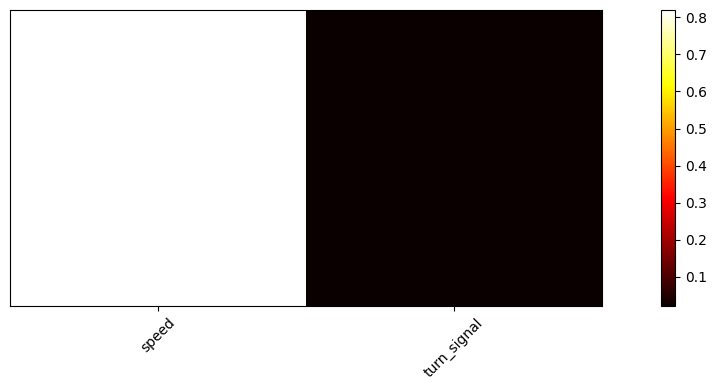

In [34]:
plot_attention(observation_summary_attn.reshape([1, -1]), ["speed", "turn_signal"])